In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from ipywidgets import interact

import sys
sys.path.append('../')

torch.manual_seed(1)

N_TRAIN = 10_000
N_SAMPLES = 4096

In [2]:
from tasks.toy_examples.data_generators import SBIGaussian2d
# Task
task = SBIGaussian2d(prior_type="gaussian")
# Prior and Simulator
prior = task.prior
simulator = task.simulator

In [3]:
from nse import NSE, NSELoss
from sm_utils import train

# Train data
theta_train = task.prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)

# score_network
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()

# avg_score_net = train(
#     model=score_net,
#     dataset=dataset,
#     loss_fn=NSELoss(score_net),
#     n_epochs=200,
#     lr=1e-3,
#     batch_size=256,
#     prior_score=False, # learn the prior score via the classifier-free guidance approach
# )
# score_net = avg_score_net.module
# torch.save(score_net, "score_net.pkl")
# torch.save(score_net, "score_net_normal_prior.pkl")
# score_net = torch.load("score_net_normal_prior.pkl")
score_net = torch.load("../score_net.pkl")

In [4]:
# meshgrid for theta space
theta1 = torch.linspace(-10, 10, 100)
theta2 = torch.linspace(-10, 10, 100)

theta1_, theta2_ = torch.meshgrid(theta1, theta2)
theta_ = torch.stack([theta1_.reshape(-1), theta2_.reshape(-1)], dim=-1)

/data/parietal/store3/work/jlinhart/miniconda3/envs/diff4sbi/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# observation
theta_true = torch.FloatTensor([-5, 150])  # true parameters
x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
x_obs_ = (x_obs - x_train.mean(axis=0)) / x_train.std(axis=0)

# true posterior
true_posterior = task.true_posterior(x_obs)

## Scores for $n=1$

In [10]:
# compute learned and analytic scores
from vp_diffused_priors import get_vpdiff_gaussian_score

# rescale true posterior
loc = (true_posterior.loc - theta_train.mean(axis=0)) / theta_train.std(axis=0)
cov = (
    torch.diag(1 / theta_train.std(axis=0))
    @ true_posterior.covariance_matrix
    @ torch.diag(1 / theta_train.std(axis=0))
)
true_posterior_ = torch.distributions.MultivariateNormal(loc=loc, covariance_matrix=cov)

# plot scores diff on meshgrid
def mesh_score_diff(t):
    t = torch.tensor(t)
    score_ana = get_vpdiff_gaussian_score(true_posterior_.loc, true_posterior_.covariance_matrix, score_net)(theta_, t=t)
    score_learned = score_net.score(theta_.cuda(), x_obs_.cuda(), t=t.cuda()).detach().cpu()

    norm_score_ana = torch.linalg.norm(score_ana, dim=-1).reshape(100, 100)
    norm_score_learned = torch.linalg.norm(score_learned, dim=-1).reshape(100, 100)
    diff_score = torch.linalg.norm(score_learned - score_ana, dim=-1).reshape(100, 100)

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].contourf(theta1_, theta2_, norm_score_learned, levels=100)
    ax[0].set_title(f"Norm learned score (t={t:.2f})")
    ax[1].contourf(theta1_, theta2_, norm_score_ana, levels=100)
    ax[1].set_title(f"Norm analytic score (t={t:.2f})")
    ax[2].contourf(theta1_, theta2_, diff_score, levels=100)
    ax[2].set_title(f"Norm difference score (t={t:.2f})")

    # add colorbar
    for i, s in zip(range(3), [norm_score_learned, norm_score_ana, diff_score]):
        fig.colorbar(ax[i].contourf(theta1_, theta2_, s, levels=100))

interact(mesh_score_diff, t=(0, 1, 0.01));


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## gradlogL for $n\geq1$

In [7]:
# compute gradlogL
from debug_learned_gaussian import diffused_tall_posterior_score

# observations
theta_true = torch.FloatTensor([-5, 150])  # true parameters
x_obs_100 = torch.cat(
    [simulator(theta_true).reshape(1, -1) for i in range(100)], dim=0
)
x_obs_100_ = (x_obs_100 - x_train.mean(axis=0)) / x_train.std(axis=0)

# normalized prior
loc_ = (prior.prior.loc - theta_train.mean(axis=0)) / theta_train.std(axis=0)
cov_ = (
    torch.diag(1 / theta_train.std(axis=0))
    @ prior.prior.covariance_matrix
    @ torch.diag(1 / theta_train.std(axis=0))
)
prior_ = torch.distributions.MultivariateNormal(loc=loc_, covariance_matrix=cov_)

get_score_fn = lambda n_obs: partial(
    diffused_tall_posterior_score,
    prior=prior_, # normalized prior
    posterior_fn_ana=task.true_posterior, # analytical posterior
    x_obs=x_obs_100[:n_obs].cuda(), # observations
    x_obs_=x_obs_100_[:n_obs].cuda(), # normalized observations
    nse=score_net, # trained score network
    # mean and std to normalize the analytical posterior
    theta_mean=theta_train.mean(axis=0),
    theta_std=theta_train.std(axis=0),
)

def mesh_gradlogL(t, n_obs):
    t = torch.tensor(t)

    # score function for tall posterior (learned and analytical)
    score_fn = get_score_fn(n_obs)

    out = score_fn(theta_.cuda(), t.cuda(), debug=True)
    gradlogL, gradlogL_ana = out[1], out[5]
    norm_gradlogL_ana = torch.linalg.norm(gradlogL_ana, dim=-1).reshape(100, 100)
    norm_gradlogL = torch.linalg.norm(gradlogL, dim=-1).reshape(100, 100).clip(0, norm_gradlogL_ana.max())
    diff_gradlogL = torch.linalg.norm(gradlogL - gradlogL_ana, dim=-1).reshape(100, 100)

    # compute number of clipped values
    n_clipped = (norm_gradlogL == norm_gradlogL_ana.max()).sum()


    # plot all quantities next to each other
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].contourf(theta1_, theta2_, norm_gradlogL, levels=100)
    axes[0].set_xlabel("theta_1")
    axes[0].set_ylabel("theta_2")
    axes[0].set_title(f"Norm gradlogL (t={t})")
    axes[1].contourf(theta1_, theta2_, norm_gradlogL_ana, levels=100)
    axes[1].set_xlabel("theta_1")
    axes[1].set_ylabel("theta_2")
    axes[1].set_title(f"Norm gradlogL_ana (t={t})")
    axes[2].contourf(theta1_, theta2_, diff_gradlogL, levels=100)
    axes[2].set_xlabel("theta_1")
    axes[2].set_ylabel("theta_2")
    axes[2].set_title(f"Norm diff gradlogL/ana (t={t})")
    fig.suptitle(f"n_obs={n_obs}, n_clipped={n_clipped}")

    # add colorbars
    for i, g in zip(range(3), [norm_gradlogL, norm_gradlogL_ana, diff_gradlogL]):
        plt.colorbar(axes[i].contourf(theta1_, theta2_, g, levels=100))

interact(mesh_gradlogL, t=(0, 1, 0.01), n_obs=(1, 100, 1)); 

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), IntSlider(value=50, descrip…

In [9]:
# plot max amplitude of gradlogL as a function of n_obs

def plot_max_gradlogL_n(t):
    t = torch.tensor(t)

    max_gradlogL = []
    max_gradlogL_ana = []

    n_list = [2, 5, 10, 20, 50]
    for n_obs in n_list: 
        # score function for tall posterior (learned and analytical)
        score_fn = get_score_fn(n_obs)

        out = score_fn(theta_.cuda(), t.cuda(), debug=True)
        gradlogL, gradlogL_ana = out[1], out[5]
        norm_gradlogL = torch.linalg.norm(gradlogL, dim=-1).reshape(100, 100)
        norm_gradlogL_ana = torch.linalg.norm(gradlogL_ana, dim=-1).reshape(100, 100)

        max_gradlogL.append(norm_gradlogL.max())
        max_gradlogL_ana.append(norm_gradlogL_ana.max())  

    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].plot(n_list, max_gradlogL)
    ax[0].set_xlabel("n_obs")
    ax[0].set_ylabel("max gradlogL")
    ax[1].plot(n_list, max_gradlogL_ana)
    ax[1].set_xlabel("n_obs")
    ax[1].set_ylabel("max gradlogL_ana")

def plot_max_gradlogL_t(n_obs):

    max_gradlogL = []
    max_gradlogL_ana = []

    t_list = [0,0.1, 0.3, 0.5, 0.7, 0.9,1]
    for t in t_list: 
        t = torch.tensor(t)
        # score function for tall posterior (learned and analytical)
        score_fn = get_score_fn(n_obs)

        out = score_fn(theta_.cuda(), t.cuda(), debug=True)
        gradlogL, gradlogL_ana = out[1], out[5]
        norm_gradlogL = torch.linalg.norm(gradlogL, dim=-1).reshape(100, 100)
        norm_gradlogL_ana = torch.linalg.norm(gradlogL_ana, dim=-1).reshape(100, 100)

        max_gradlogL.append(norm_gradlogL.max())
        max_gradlogL_ana.append(norm_gradlogL_ana.max())  

    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].plot(t_list, max_gradlogL)
    ax[0].set_xlabel("n_obs")
    ax[0].set_ylabel("max gradlogL")
    ax[1].plot(t_list, max_gradlogL_ana)
    ax[1].set_xlabel("n_obs")
    ax[1].set_ylabel("max gradlogL_ana")

interact(plot_max_gradlogL_n, t=(0, 1, 0.01));

interact(plot_max_gradlogL_t, n_obs=(1, 50, 1)); 

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

interactive(children=(IntSlider(value=25, description='n_obs', max=50, min=1), Output()), _dom_classes=('widge…

## Samples


In [52]:
true_samples = true_posterior.sample((N_SAMPLES,))

def plot_samples(n_obs, t_idx):
    results = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
    results_ana = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_assure_psd.pkl")
    thetas_t = results["all_theta_learned"][t_idx] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    thetas_ana_t = results_ana["all_theta_ana"][t_idx] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(*true_samples.T, s=1, alpha=0.1, c="blue")
    ax[0].scatter(thetas_t[:, 0], thetas_t[:, 1], s=1, alpha=0.1, c="orange")
    ax[0].scatter(theta_true[0], theta_true[1], marker='*', alpha=1, c="black")
    ax[0].set_title(f"Learned posterior (n_obs={n_obs})")
    # ax[0].set_xlim(-10, 0)
    # ax[0].set_ylim(130, 170)
    ax[0].set_xlabel("theta_1")
    ax[0].set_ylabel("theta_2")
    ax[1].scatter(*true_samples.T, s=1, alpha=0.1, c="blue")
    ax[1].scatter(thetas_ana_t[:, 0], thetas_ana_t[:, 1], s=1, alpha=0.1, c="red")
    ax[1].scatter(theta_true[0], theta_true[1], marker='*', alpha=1, c="black")
    ax[1].set_title(f"Analytical posterior (n_obs={n_obs})")
    # ax[1].set_xlim(-10, 0)
    # ax[1].set_ylim(130, 170)
    ax[1].set_xlabel("theta_1")
    ax[1].set_ylabel("theta_2")
    
interact(plot_samples, n_obs=[2, 20, 50, 100], t_idx=(950, 999, 1));

interactive(children=(Dropdown(description='n_obs', options=(2, 20, 50, 100), value=2), IntSlider(value=974, d…

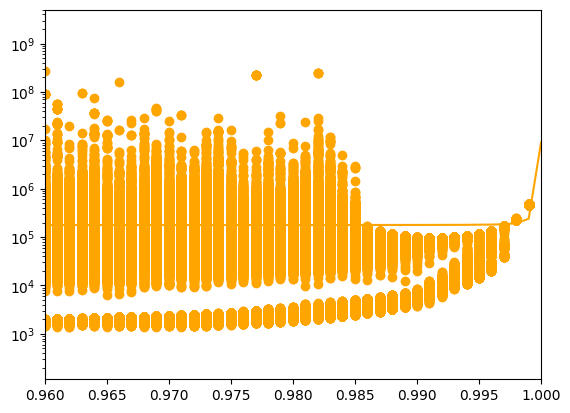

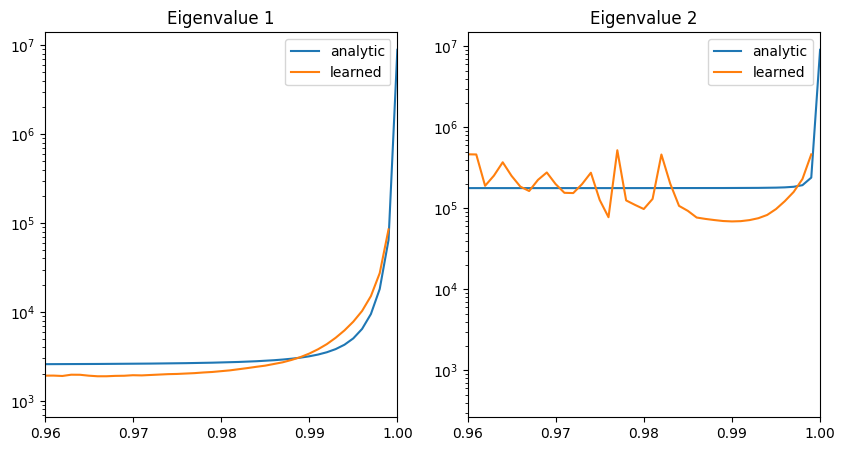

In [10]:
n_obs = 100
results = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
lda = results["lda"]
lda_ana = results["lda_ana"]

lda_ana_eigvals = torch.linalg.eigvals(lda_ana).real
lda_eigvals = torch.linalg.eigvals(lda).real

t = torch.linspace(0, 1, results["all_theta_learned"].shape[0])

# plt.plot(score_net.alpha(t)**.5, lda_ana_eigvals.min(dim=-1).values, 'bx')
# plt.scatter((torch.flip(score_net.alpha(t)**.5, dims=(0,)))[:-1][:, None].repeat(1, lda_eigvals.shape[1]), lda_eigvals.min(dim=-1).values, color='blue')
# plt.plot(score_net.alpha(t) ** .5, lda_ana_eigvals.max(dim=-1).values, 'rx')
# plt.scatter((torch.flip(score_net.alpha(t) ** .5, dims=(0,)))[:-1][:, None].repeat(1, lda_eigvals.shape[1]),
#             lda_eigvals.max(dim=-1).values, color='red')

plt.plot(torch.flip(t, dims=(0,)), lda_ana_eigvals.max(dim=-1).values, color='orange')
plt.scatter(t[:-1][:, None].repeat(1, lda_eigvals.shape[1]), lda_eigvals.max(dim=-1).values, color='orange')
plt.yscale('log')
plt.xlim(.96, 1)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(torch.flip(t, dims=(0,)),lda_ana_eigvals[:,0], label="analytic")
ax[0].plot(t[:-1], lda_eigvals.mean(axis=1)[:,0], label="learned")
ax[0].legend()
ax[0].set_title("Eigenvalue 1")
ax[0].set_yscale('log')
ax[0].set_xlim(.96, 1)
ax[1].plot(torch.flip(t, dims=(0,)),lda_ana_eigvals[:,1], label="analytic")
ax[1].plot(t[:-1],lda_eigvals.mean(axis=1)[:,1], label="learned")
ax[1].legend()
ax[1].set_title("Eigenvalue 2")
ax[1].set_yscale('log')
ax[1].set_xlim(.96, 1)
plt.show()

In [72]:
from ot import sliced_wasserstein_distance
n_obs = 20
results = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
results_w3 = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_lda_criteria_0.3.pkl")

results_ = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_no_gradlogL.pkl")
results_ana = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_assure_psd.pkl")

wd = []
wd_ = []
wd_w3 = []
for t in range(0, 999, 1):
    P = results["all_theta_learned"][t] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    P_ = results_["all_theta_learned"][t] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    P_w3 = results_w3["all_theta_learned"][t] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    Q = results_ana["all_theta_ana"][t] * theta_train.std(axis=0) + theta_train.mean(axis=0)
    # compute the sliced wasserstein distance
    wd.append(sliced_wasserstein_distance(P, Q))
    wd_.append(sliced_wasserstein_distance(P_, Q))
    wd_w3.append(sliced_wasserstein_distance(P_w3, Q))



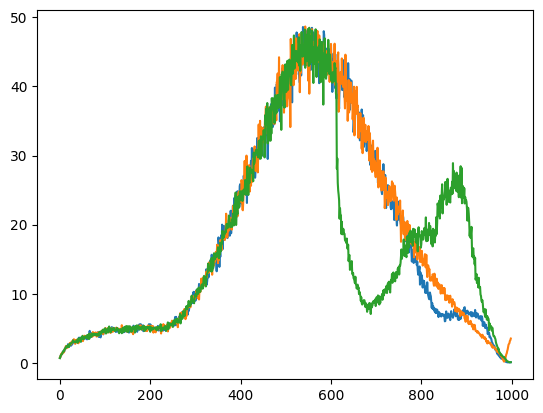

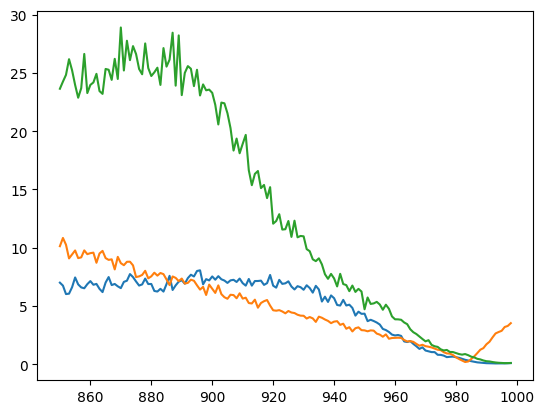

In [73]:
plt.plot(torch.arange(0,999,1), wd)
plt.plot(torch.arange(0,999,1), wd_)
plt.plot(torch.arange(0,999,1), wd_w3)
plt.show()

plt.plot(torch.arange(0,999,1)[850:], wd[850:])
plt.plot(torch.arange(0,999,1)[850:], wd_[850:])
plt.plot(torch.arange(0,999,1)[850:], wd_w3[850:])
plt.show()


In [68]:
n_obs = 25
t_idx=-1
results = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
# results_ana = torch.load(f"../results/gaussian/results_dict_n_obs_{n_obs}_assure_psd.pkl")
thetas_t = results["all_theta_learned"][t_idx] * theta_train.std(axis=0) + theta_train.mean(axis=0)
# thetas_ana_t = results_ana["all_theta_ana"][t_idx] * theta_train.std(axis=0) + theta_train.mean(axis=0)


Text(0, 0.5, 'theta_2')

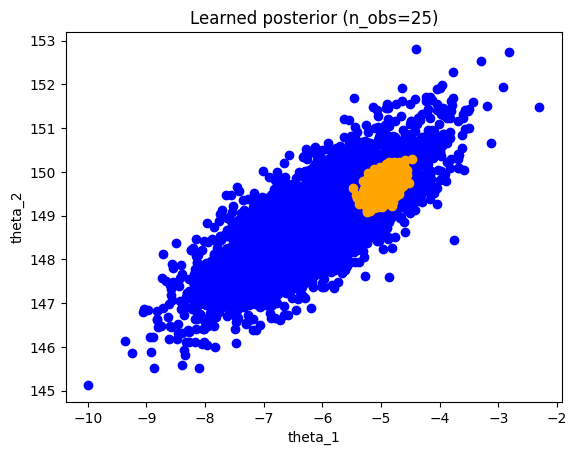

In [69]:
plt.scatter(*true_samples.T, c="blue")
# plt.scatter(thetas_ana_t[:, 0], thetas_ana_t[:, 1], c="red")
plt.scatter(thetas_t[:, 0], thetas_t[:, 1], c="orange")
# plt.scatter(theta_true[0], theta_true[1], marker='*', alpha=1, c="black")
plt.title(f"Learned posterior (n_obs={n_obs})")
# plt.xlim(-10, 0)
# plt.ylim(130, 170)
plt.xlabel("theta_1")
plt.ylabel("theta_2")